In [60]:
from ultralytics import YOLO
import cv2
import math
import torch
import numpy as np

In [61]:
FIRE_WEIGHTS = "ML Models/Fire/fire.pt"
WEAPONS_WEIGHTS = "ML Models/weapons detection/best.pt"
VIOLENCE_WEIGHTS = "ML Models/Violence Detection/ViolenceDet.pt"
ABDUCTION_WEIGHTS = "ML Models/Abduction detection/best (2).pt"

In [62]:
classes = {
    "generic": ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ],
    "fire" : ["fire","smoke"],
    "violence":["Violence","Weapons"],
    "weapons" : ["Grenade","Handgun","Rifle","Steel arms"],
    "abduction":["Kidnap", "Non Kidnap"]
}

In [63]:
models = {}
models["generic"] = YOLO("yolov8n.pt")
models["fire"] = YOLO(FIRE_WEIGHTS)
models["weapons"] = YOLO(WEAPONS_WEIGHTS)
models["violence"] = YOLO(VIOLENCE_WEIGHTS)
models["abduction"] = YOLO(ABDUCTION_WEIGHTS)

In [64]:
import time

In [65]:
import numpy as np
import cv2
import pygame
import matplotlib.pyplot as plt
# Initialize pygame
pygame.mixer.init()

# Load siren sound
siren_sound = pygame.mixer.Sound('police-6007.mp3')

# Video capturing starts
def tampering(frame):
    # cap = cv2.VideoCapture(0)
    fgbg = cv2.createBackgroundSubtractorMOG2()
    # ret, frame = cap.read()
    fgmask = fgbg.apply(frame)
    kernel = np.ones((5,5), np.uint8)
    
    if frame is None:
        print("End of frame")
    else:
        a = 0
        bounding_rect = []
        fgmask = fgbg.apply(frame)
        fgmask = cv2.erode(fgmask, kernel, iterations=5) 
        fgmask = cv2.dilate(fgmask, kernel, iterations=5)
        cv2.imshow('frame', frame)
        contours, _ = cv2.findContours(fgmask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for i in range(len(contours)):
            bounding_rect.append(cv2.boundingRect(contours[i]))
        for i in range(len(contours)):
            if bounding_rect[i][2] >= 40 or bounding_rect[i][3] >= 40:
                a = a + (bounding_rect[i][2]) * bounding_rect[i][3]
            if a >= int(frame.shape[0]) * int(frame.shape[1]) / 3:
                cv2.putText(frame, "TAMPERING DETECTED", (5, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
                # Play siren sound
                siren_sound.play()
            cv2.imshow('frame', frame)

pygame 2.5.2 (SDL 2.28.3, Python 3.11.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [66]:
import pandas as pd
import os
def create_csv():
  try:
    df = pd.read_csv('anomalies.csv')
  except FileNotFoundError:
    df = pd.DataFrame(columns=['Timestamp','Type of anomaly' ,'Number of People present', 'Path of image'])
    df.to_csv('anomalies.csv', index=False)
  return df

def append_to_csv(df, timestamp, num_inmates, image_path, typeofanomaly=""):
  new_data = {'Timestamp': timestamp, 'Type of anomaly':typeofanomaly, 'Number of People present': num_inmates, 'Path of image': image_path}
  new_data_df = pd.DataFrame.from_dict(new_data, orient='index').T
  df = pd.concat([df, new_data_df], ignore_index=True)
  df.to_csv('anomalies.csv', index=False)

inmatesthresholdtime = 2
anomaly_count = {} 
df = create_csv()

def process_model(model, img, classNames, model_name, numinmates , savetodir="frames"):
    global inmatesthresholdtime, anomaly_count, df
    
    results = model(img, stream=True)
    inmates = 0
    anomalies = []
    typeofanomaly = {
            "generic": "crowd",
            "fire": "Fire",
            "weapons": "Weapons",
            "violence": "Violence",
            "abduction": "Abduction"
        }
    for r in results:
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls[0])
            confidence = math.ceil((box.conf[0]*100))/100
            if confidence < 0.6:
                continue
            if cls >= len(classNames):
                print("Error: Class index out of range")
                continue
            accepted_list = ["person", "fire", "Grenade", "Handgun", "Rifle", "Steel arms","Violence","Kidnap", "Not Kidnap"]
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)
            if model_name == "generic" and classNames[cls] == "person":
                inmates += 1
            if classNames[cls] in accepted_list:
                anomaly_key = (model_name, classNames[cls])
                anomaly_count[anomaly_key] = anomaly_count.get(anomaly_key, 0) + 1
                if anomaly_count[anomaly_key] >= 1:
                    timestamp = time.strftime('%Y-%m-%d %H:%M:%S') 
                    anomaly_text = f"{classNames[cls]} detected, storing the frame in the database as {savetodir}/{timestamp}.jpg at {timestamp}.\n"
                    print(anomaly_text)
                    anomalies.append(anomaly_text)
                    anomaly_count[anomaly_key] = 0
                    df = create_csv()
                    # if model_name == "generic" and inmates > numinmates:
                    #   append_to_csv(df, timestamp, inmates, f"{savetodir}/{timestamp}.jpg", typeofanomaly[model_name])
                    # elif model_name != "generic":
                    #   append_to_csv(df, timestamp, inmates, f"{savetodir}/{timestamp}.jpg", typeofanomaly[model_name])
                    with open("anomalies.txt", "a") as f:
                        f.write(anomaly_text)
                    # create the directory if it does not exist
                    if not os.path.exists(savetodir):
                        os.makedirs(savetodir)
                    cv2.imwrite(filename=savetodir+"/"+timestamp+".jpg", img=img)
                    
                    
            print("Confidence --->", confidence)
            print("Class name -->", classNames[cls])
            org = [x1, y1]
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 1
            color = (255, 0, 0)
            thickness = 2
            cv2.putText(img, classNames[cls], org, font, fontScale, color, thickness)
            
    if inmatesthresholdtime <= 0:
        inmatesthresholdtime = 2
    else:
        inmatesthresholdtime -= 1

    with open("anomalies.txt", "a") as f:
        f.write(" ".join(anomalies) )

def start_webcam(models, classes):
  cap = cv2.VideoCapture(0)
  while True:
    ret, frame = cap.read()
    if not ret:
      print("Error: Unable to capture frame")
      break
    for model_name, model in models.items():
      process_model(model, frame.copy(), classes[model_name], model_name, 10)  # Pass a copy of frame to avoid modification across models
    cv2.imshow("frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  cap.release()
  cv2.destroyAllWindows()

In [67]:
# run the function on demo video
def start_demo(models, classes):
    cap = cv2.VideoCapture("ML Models/weapons detection/gun.mp4")
    i = 0
    while True:
        i += 1
        print(f"{i}th frame")
        ret, frame = cap.read()
        if i%10 != 0:
            continue
        if not ret:
            print("Error: Unable to capture frame")
            break
        if cv2.waitKey(1) & 0xFF == ord('q'):
                break 
        for model_name, model in models.items():
            anomaly_detected = process_model(model, frame.copy(), classes[model_name], model_name, 10)  # Pass a copy of frame to avoid modification across models
        if anomaly_detected:
            try:
                tampering(frame)
            except Exception as e:
                print("An error occurred while tampering the image:", e)
            cv2.imshow("frame", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    cap.release()
    cv2.destroyAllWindows()

In [14]:
start_demo(models, classes)


1th frame
2th frame
3th frame
4th frame
5th frame
6th frame
7th frame
8th frame
9th frame
10th frame

0: 384x640 (no detections), 2193.0ms
Speed: 83.7ms preprocess, 2193.0ms inference, 42.2ms postprocess per image at shape (1, 3, 384, 640)

0: 256x448 (no detections), 1898.0ms
Speed: 15.2ms preprocess, 1898.0ms inference, 5.5ms postprocess per image at shape (1, 3, 256, 448)

0: 256x448 (no detections), 1962.0ms
Speed: 28.7ms preprocess, 1962.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 448)

0: 256x448 (no detections), 1116.3ms
Speed: 4.5ms preprocess, 1116.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 448)

0: 256x448 (no detections), 1349.7ms
Speed: 9.5ms preprocess, 1349.7ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 448)
11th frame
12th frame
13th frame
14th frame
15th frame
16th frame
17th frame
18th frame
19th frame
20th frame

0: 384x640 (no detections), 927.4ms
Speed: 13.6ms preprocess, 927.4ms inference, 6.0ms postprocess 

KeyboardInterrupt: 

In [ ]:
start_webcam(models=models, classes=classes)

In [68]:
import lida
from lida import llm, Manager, TextGenerationConfig
import pandas as pd
import os

In [69]:
os.environ["COHERE_API_KEY"] = "hk305qjjFaCIXME1dGS0OIIHDth4NFnTtuzpPCOg"

In [84]:
# Load your data (replace with your data source)
data = pd.read_csv("anomalies.csv")

lida = Manager(text_gen=llm("cohere"))  # Assuming llm is a function to create a LLM object
textgen_config = TextGenerationConfig(n=2, temperature=0.5, use_cache=True)  # Set n to 2 for 2 goals

try:
    # Summarize data with default method
    textgen_config.n = 1  # Set n to 1 for a single summary
    summary = lida.summarize(data=data, summary_method="default", textgen_config=textgen_config)

    # Define security guard persona
    persona = "I am a security guard at a prison. I want to be able to identify and respond to potential threats effectively based on prison anomaly data."

    # Generate goals based on summary and persona
    personal_goals = lida.goals(summary, n=2, persona=persona, textgen_config=textgen_config)

    # Display generated goals
    for goal in personal_goals:
        print(goal)

except Exception as e:
    print("Error:", e)

Error: 1 validation error for Goal
visualization
  Input should be a valid string [type=string_type, input_value={'type': 'Histogram', 'qu...', ' Type of Anomaly ']}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/string_type


In [78]:
i = 0
library = "matplotlib"

charts = lida.visualize(summary=summary, goal=goal, textgen_config=textgen_config, library=library)  

for chart in charts:
    try:
        chart.show()
    except Exception as e:
        print(e)

 ```python
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot(data: pd.DataFrame):
    # plot the number of abduction against the type of anomaly
    data['Total no of Abduction'] = data['No of Abduction']
    data['Type of Abduction'] = data['Type of anomaly']

    plt.bar(data['Type of Abduction'], data['Total no of Abduction'])
    plt.title('What is the correlation between Type of anomaly and Total no of Abduction?', wrap=True)
    plt.xlabel('Type of Abduction')
    plt.ylabel('Total no of Abduction')
    plt.legend(['Total no of Abduction'])
    return plt;

chart = plot(data) 
```
****
 'No of Abduction'
 ```python
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot(data: pd.DataFrame):
    # plot the number of abduction against the type of anomaly
    data['Total no of Abduction'] = data['No of Abduction']
    data['Type of Abduction'] = data['Type of anomaly']

    plt.bar(data['Type of Abduction'], data['Total n

In [ ]:
import langchain
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain.prompts import PromptTemplate
from langchain_community.llms.huggingface_hub import HuggingFaceHub
from langchain_community.chat_models import ChatHuggingFace
import os
from dotenv import load_dotenv, get_key

os.environ["HUGGINGFACEHUB_API_TOKEN"] = get_key(key_to_get="HUGGINGFACEHUB_API_KEY",dotenv_path=".env")

llm = HuggingFaceHub(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.5,
        "repetition_penalty": 1.03,
    },
)

def chatwithbot(txt:str):
    prompt = PromptTemplate(template= "You're a helpful security assistant. You've been asked to help authorities. They want to be able to detect securty concerns in the city. They've provided you with a list of anomalies in the city with type of anomaly and timestamp.Answer questions of user from given data. Here's the data:\n{data}", input_variables=["data"])

    chat_model = ChatHuggingFace(llm=llm)
    # get the data from anomalies.txt
    with open("anomalies.txt", "r") as f:
        data = f.read()
    if len(data) == 0:
        data = "No anomalies detected"

    final_prompt = prompt.format(data=data)
    user_template= PromptTemplate(template="{user_input}", input_variables=["user_input"])

    messages = [
    SystemMessage(content=final_prompt),
    HumanMessage(content=user_template.format(user_input=txt))
    ]
    print(chat_model(messages))
    res = chat_model(messages).content
    res = res[res.find("<|assistant|>")+len("<|assistant|>"):]
    return res


In [ ]:

def chat():
    while True:
        txt = input("Enter your message: ")
        if txt == "exit":
            break
        res = chatwithbot(txt)
        print(res)

In [ ]:
chat()

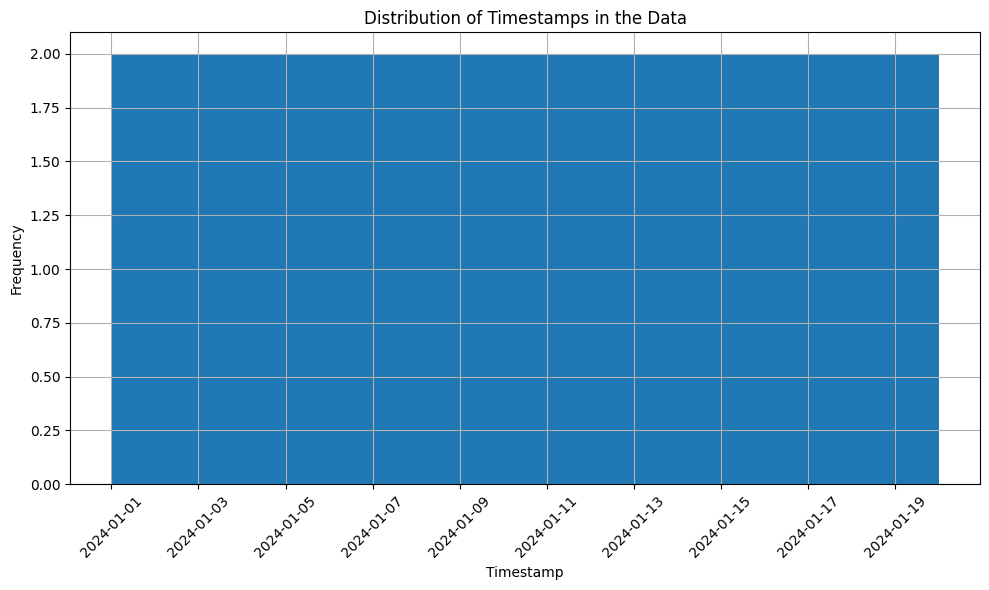

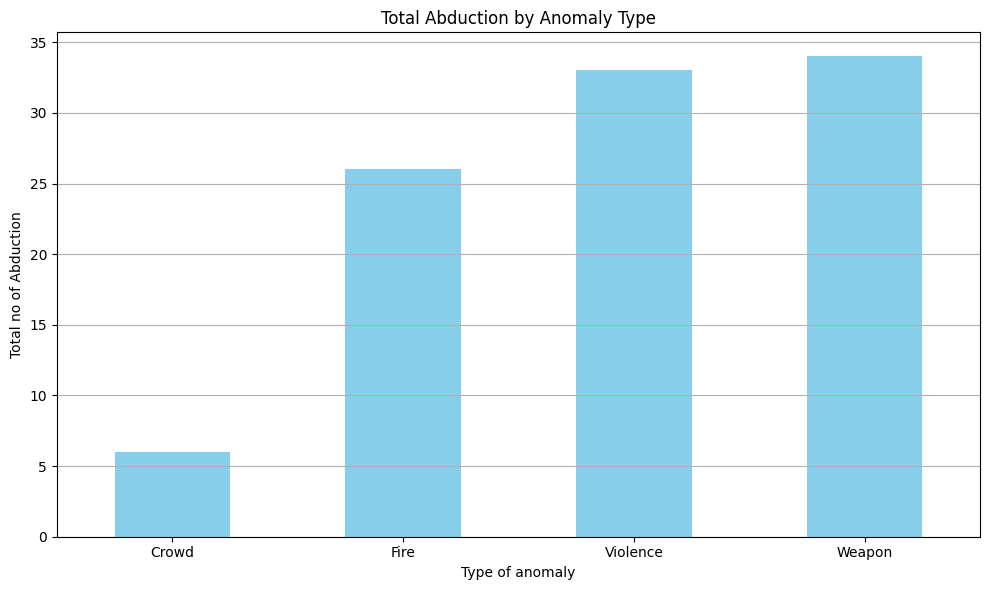